In [1]:
import numpy as np
import joblib
from CNN_AE import CNNAutoencoder
from helper import *
from optimizer import GPOptimizer, DeepGPOptimizer
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [3]:
w = np.load('Kolmogorov_Data/vorticity.npy')
u = np.load('Kolmogorov_Data/u1.npy')
v = np.load('Kolmogorov_Data/u2.npy')

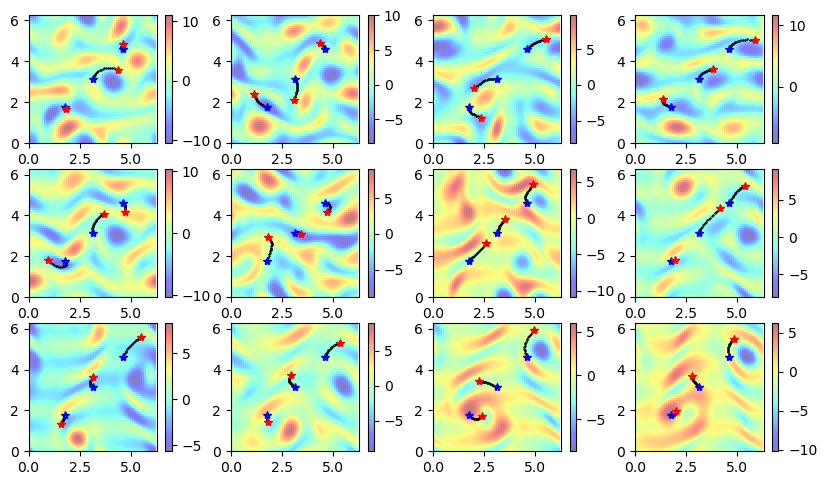

In [4]:
dt = 0.05
T = 1
dts = [dt for _ in range(int(T / dt))]

nsamples = 1000
delta = nt // nsamples
tsteps = [(i+1)*delta - 1 for i in range(nsamples)]
nsamples = len(tsteps)
num_traj = 3

trajectories = {}
for tstep in tsteps:
    trajectories[tstep] = {}
    for traj_i in range(num_traj):
        trajectories[tstep][traj_i] = np.load(f'Kolmogorov_Results/ConstantTrajData/{tstep}/traj_{traj_i}.npy')

plt.figure(figsize=(10,int(np.ceil(nsamples/4))*2))

for sample_i, tstep in enumerate(tsteps[:12]):
    w_plot = w[tstep, :, :]
            
    ax = plt.subplot(int(np.ceil(nsamples/4)), 4, sample_i+1)
    c = plot_trajectories(ax, w_plot, grid_x, grid_y, trajectories[tstep], 0, L1, 0, L2, cmap='jet')
    plt.colorbar(c)

In [5]:
latent_dim = 50
activation = 'relu'
nn = CNNAutoencoder(latent_dim=latent_dim)

nn.load_state_dict(torch.load(f"Kolmogorov_Models/CNN_AE_{activation}_{latent_dim}.pth"))
nn.to(device)
D = nn.decode

data, nn_scaler = transform_data_for_AE(u,v)
latent_space = get_latent_space(nn, data)

latent_inputs = gaussian_kde(latent_space)

In [6]:
acquisition_function = 'LCB'
# acquisition_function = 'EI'

deep = True

if latent_dim == 50:
    deep = True
    n_iter = 75
else:
    n_iter = 100

optimizers = {}
for tstep in tsteps:
    if deep:
        optimizers[tstep] =  DeepGPOptimizer(trajectories[tstep], dts, trajectory_cost_function, D, latent_inputs, grid_x, grid_y, nn_scaler, device, acquisition_function, n_init=0, train_init=False)
    else:
        optimizers[tstep] = GPOptimizer(trajectories[tstep], dts, trajectory_cost_function, D, latent_inputs, grid_x, grid_y, nn_scaler, device, acquisition_function, n_init=0, train_init=False)

In [9]:
load_data = True
if deep:
    tag = ''
else:
    tag = 'GP_'

tsteps_copy = tsteps.copy()
if load_data:
    for tstep in tsteps:
        exp_path = f'Kolmogorov_Results/ConstantTrajData/{tstep}/{tag}{acquisition_function}_{latent_dim}'

        # Load data only if the path exists
        if os.path.exists(exp_path):
            optimizer = optimizers[tstep]
            optimizer.X = np.load(os.path.join(exp_path, 'X.npy'))
            optimizer.Y = np.load(os.path.join(exp_path, 'Y.npy'))            
            optimizer.scaler_gp_x = joblib.load(f'{exp_path}/scaler_gp_x.joblib')
            optimizer.scaler_gp_y = joblib.load(f'{exp_path}/scaler_gp_y.joblib')
        else:
            print(f'Warning: Path {exp_path} does not exist')
            tsteps_copy.remove(tstep)

tsteps = tsteps_copy

In [10]:
z_opt, u_opt, v_opt, w_opt, traj_opt = [], [], [], [], []
u_err, v_err, w_err = [], [], []
for tstep in tsteps:
    u_true = u[tstep, :, :]
    v_true = v[tstep, :, :]
    w_true = w[tstep, :, :]

    optimizer = optimizers[tstep]
    k=1
    
    if k == 1:
        z_i, u_i, v_i, traj_i = optimizer.get_optimal()
    else:
        _, _, _, traj_i = optimizer.get_top_k(k=k)
        u_i, v_i = optimizer.get_top_k_mean(k=k)
    
    w_i = vort(u_i, v_i, kx, ky)
    # z_opt.append(z_i)
    u_opt.append(u_i)
    v_opt.append(v_i)
    w_opt.append(w_i)
    traj_opt.append(traj_i)

    u_err.append(u_true - u_i)
    v_err.append(v_true - v_i)
    w_err.append(w_true - w_i)



 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [11]:
init_pos = np.array([trajectories[19][i][0] for i in range(num_traj)])

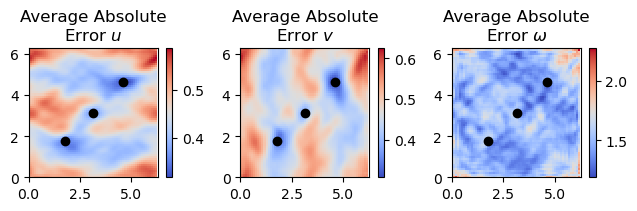

In [16]:
# Compute the average of absolute errors across all samples
avg_u_err = np.mean([np.abs(err) for err in u_err], axis=0)
avg_v_err = np.mean([np.abs(err) for err in v_err], axis=0)
avg_w_err = np.mean([np.abs(err) for err in w_err], axis=0)

# Plot the average errors
plt.subplots(figsize=(6.5, 2))
plt.subplot(1, 3, 1)
plt.pcolormesh(grid_x, grid_y, avg_u_err, cmap='coolwarm')
for i in range(num_traj):
    plt.plot(init_pos[i][0], init_pos[i][1], 'ko')
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.gca().set_aspect('equal')
plt.colorbar(shrink=0.9)
plt.title('Average Absolute\nError $u$')

plt.subplot(1, 3, 2)
plt.pcolormesh(grid_x, grid_y, avg_v_err, cmap='coolwarm')
for i in range(num_traj):
    plt.plot(init_pos[i][0], init_pos[i][1], 'ko')
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.gca().set_aspect('equal')
plt.colorbar(shrink=0.9)
plt.title('Average Absolute\nError $v$')

plt.subplot(1, 3, 3)
plt.pcolormesh(grid_x, grid_y, avg_w_err, cmap='coolwarm')
for i in range(num_traj):
    plt.plot(init_pos[i][0], init_pos[i][1], 'ko')
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.gca().set_aspect('equal')
plt.colorbar(shrink=0.9)
plt.title('Average Absolute\nError $\omega$')

plt.tight_layout()

plt.savefig(f'Kolmogorov_Figures/constant_traj_average_errors_{nsamples}_{tag}{acquisition_function}_{latent_dim}_.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# def plot_subplot(ax, grid_x, grid_y, data, title, cmap='jet', vmin=None, vmax=None, cb_shrink=0.3):
#     """Helper function to plot a single subplot."""
#     c = ax.pcolormesh(grid_x, grid_y, data, cmap=cmap, vmin=vmin, vmax=vmax)
#     ax.set_title(title)
#     ax.set_aspect('equal')
#     plt.colorbar(c, ax=ax, shrink=cb_shrink)


# cb_shrink = 0.7
# """Create the figure and plot subplots."""
# plt.figure(figsize=(12, nsamples * 1.7))

# for sample_i in range(nsamples):

#     rmse_u = np.sqrt(np.mean(u_err[sample_i]**2))
#     rmse_v = np.sqrt(np.mean(v_err[sample_i]**2))
#     rmse_w = np.sqrt(np.mean(w_err[sample_i]**2))

#     # Plot u
#     ax1 = plt.subplot(nsamples, 6, 6 * sample_i + 1)
#     plot_subplot(ax1, grid_x, grid_y, u[tsteps[sample_i], :, :], f"$u$", vmin=-1.5, vmax=1.5, cb_shrink=cb_shrink)

#     ax2 = plt.subplot(nsamples, 6, 6 * sample_i + 2)
#     plot_subplot(ax2, grid_x, grid_y, u_opt[sample_i], f"$u$* (RMSE: {rmse_u:.2f})", vmin=-1.5, vmax=1.5, cb_shrink=cb_shrink)

#     # Plot v
#     ax3 = plt.subplot(nsamples, 6, 6 * sample_i + 3)
#     plot_subplot(ax3, grid_x, grid_y, v[tsteps[sample_i], :, :], f"$v$", vmin=-1.5, vmax=1.5, cb_shrink=cb_shrink)

#     ax4 = plt.subplot(nsamples, 6, 6 * sample_i + 4)
#     plot_subplot(ax4, grid_x, grid_y, v_opt[sample_i], f"$v$* (RMSE: {rmse_v:.2f})", vmin=-1.5, vmax=1.5, cb_shrink=cb_shrink)

#     # Plot w
#     ax5 = plt.subplot(nsamples, 6, 6 * sample_i + 5)
#     plot_subplot(ax5, grid_x, grid_y, w[tsteps[sample_i], :, :], f"$\omega$", vmin=-8, vmax=8, cb_shrink=cb_shrink)

#     ax6 = plt.subplot(nsamples, 6, 6 * sample_i + 6)
#     plot_subplot(ax6, grid_x, grid_y, w_opt[sample_i], f"$\omega$* (RMSE: {rmse_w:.2f})", vmin=-8, vmax=8, cb_shrink=cb_shrink)

# plt.tight_layout()
